<a href="https://colab.research.google.com/github/MOIPA/AiCourse/blob/master/19%E7%9B%AE%E6%A0%87%E6%A3%80%E6%B5%8B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install d2l

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.9/58.9 kB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.7/111.7 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 30.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 27.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 27.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.6/62.6 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.3/98.3 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.0/125.0 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 50.4 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.32.3
    Uninstalling requests-2.32.3:
      Successful

In [ ]:
%matplotlib inline
import torch
from d2l import torch as d2l

Exception ignored in: <function WeakSet.__init__.<locals>._remove at 0x7f0d24fb4280>
Traceback (most recent call last):
  File "/usr/lib/python3.10/_weakrefset.py", line 39, in _remove
    def _remove(item, selfref=ref(self)):
KeyboardInterrupt: 


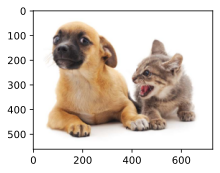

In [ ]:
d2l.set_figsize()
img = d2l.plt.imread('/content/catdog.jpg')
d2l.plt.imshow(img);

In [ ]:
def box_corner_to_center(boxes):
    """从（左上，右下）转换到（中间，宽度，高度）"""
    x1, y1, x2, y2 = boxes[:, 0], boxes[:, 1], boxes[:, 2], boxes[:, 3]
    cx = (x1 + x2) / 2
    cy = (y1 + y2) / 2
    w = x2 - x1
    h = y2 - y1
    boxes = torch.stack((cx, cy, w, h), axis=-1)
    return boxes

def box_center_to_corner(boxes):
    """从（中间，宽度，高度）转换到（左上，右下）"""
    cx, cy, w, h = boxes[:, 0], boxes[:, 1], boxes[:, 2], boxes[:, 3]
    x1 = cx - 0.5 * w
    y1 = cy - 0.5 * h
    x2 = cx + 0.5 * w
    y2 = cy + 0.5 * h
    boxes = torch.stack((x1, y1, x2, y2), axis=-1)
    return boxes

In [ ]:
# bbox是边界框的英文缩写
dog_bbox, cat_bbox = [60.0, 45.0, 378.0, 516.0], [400.0, 112.0, 655.0, 493.0]

In [ ]:
boxes = torch.tensor((dog_bbox, cat_bbox))
box_center_to_corner(box_corner_to_center(boxes)) == boxes

tensor([[True, True, True, True],
        [True, True, True, True]])

In [ ]:
boxes.shape

torch.Size([2, 4])

In [ ]:
def bbox_to_rect(bbox, color):
    # 将边界框(左上x,左上y,右下x,右下y)格式转换成matplotlib格式：
    # ((左上x,左上y),宽,高)
    return d2l.plt.Rectangle(
        xy=(bbox[0], bbox[1]), width=bbox[2]-bbox[0], height=bbox[3]-bbox[1],
        fill=False, edgecolor=color, linewidth=2)

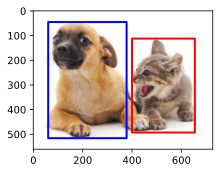

In [ ]:
fig = d2l.plt.imshow(img)
fig.axes.add_patch(bbox_to_rect(dog_bbox, 'blue'))
fig.axes.add_patch(bbox_to_rect(cat_bbox, 'red'));

# 香蕉的数据集检测

In [ ]:
%matplotlib inline
import os
import pandas as pd
import torch
import torchvision
from d2l import torch as d2l

d2l.DATA_HUB['banana-detection'] = (
    d2l.DATA_URL + 'banana-detection.zip',
    '5de26c8fce5ccdea9f91267273464dc968d20d72')

In [ ]:
def read_data_bananas(is_train=True):
    """读取香蕉检测数据集中的图像和标签"""
    data_dir = d2l.download_extract('banana-detection')
    csv_fname = os.path.join(data_dir, 'bananas_train' if is_train
                             else 'bananas_val', 'label.csv')
    csv_data = pd.read_csv(csv_fname)
    csv_data = csv_data.set_index('img_name'  )#set_index方法，可以将某一列的数据作为索引
    images, targets = [], []
    for img_name, target in csv_data.iterrows():
        images.append(torchvision.io.read_image(
            os.path.join(data_dir, 'bananas_train' if is_train else
                         'bananas_val', 'images', f'{img_name}')))
        # 这里的target包含（类别，左上角x，左上角y，右下角x，右下角y），
        # 其中所有图像都具有相同的香蕉类（索引为0）
        targets.append(list(target))
        # unsqueeze（1）在维度1上添加维度 正常应该是 批次，物品类别，类别信息 三个维度，这里因为只有香蕉，少了一个维度
    return images, torch.tensor(targets).unsqueeze(1) / 256  # /256 每个图片是256大小，变为坐标百分比，后面还会乘输出图片大小也是256

In [ ]:
class BananasDataset(torch.utils.data.Dataset):
    """一个用于加载香蕉检测数据集的自定义数据集"""
    def __init__(self, is_train):
        self.features, self.labels = read_data_bananas(is_train)
        print(f'features shape: {self.labels[0][0]}')
        print('read ' + str(len(self.features)) + (f' training examples' if
              is_train else f' validation examples'))

    def __getitem__(self, idx):
        return (self.features[idx].float(), self.labels[idx])

    def __len__(self):
        return len(self.features)

In [ ]:
def load_data_bananas(batch_size):
    """加载香蕉检测数据集"""
    train_iter = torch.utils.data.DataLoader(BananasDataset(is_train=True),
                                             batch_size, shuffle=True)
    val_iter = torch.utils.data.DataLoader(BananasDataset(is_train=False),
                                           batch_size)
    return train_iter, val_iter

In [ ]:
batch_size, edge_size = 32, 256
train_iter, _ = load_data_bananas(batch_size)
batch = next(iter(train_iter))
batch[0].shape, batch[1].shape

features shape: tensor([0.0000, 0.4062, 0.0781, 0.5586, 0.2266])
read 1000 training examples
features shape: tensor([0.0000, 0.7148, 0.2461, 0.9414, 0.4375])
read 100 validation examples


(torch.Size([32, 3, 256, 256]), torch.Size([32, 1, 5]))

以下是对代码`imgs = (batch[0][0:10].permute(0, 2, 3, 1)) / 255`的详细解释：

### 1. `batch[0][0:10]`
- 假设`batch`是一个包含多个数据批次的结构（比如在深度学习中用于存储一批图像和对应的标签等信息），`batch[0]`通常表示获取这批数据中的图像数据部分（这只是一种常见的假设，具体含义取决于`batch`的实际结构）。
- `batch[0][0:10]`表示从图像数据中选取前10个图像。这里的索引`0`表示第一个维度，通常在图像批次数据中，第一个维度代表图像的数量。所以这一步操作是从整个图像批次中提取出了前10个图像。

### 2. `permute(0, 2, 3, 1)`
- `permute`函数用于对张量的维度进行重排。对于图像数据，常见的维度顺序有`(batch_size, channel, height, width)`（例如在PyTorch中处理图像数据时）。
- 这里`permute(0, 2, 3, 1)`表示将维度重新排列。原始维度顺序假设是`(batch_size, channel, height, width)`，重排后维度顺序变为`(batch_size, height, width, channel)`。这种重排可能是为了满足后续处理步骤对图像数据维度顺序的要求，或者是与特定的模型输入格式相匹配。

### 3. `/ 255`
- 这一步是对重排后的图像数据进行归一化操作。将图像数据中的每个像素值除以255。在图像处理中，如果图像像素值的范围是0 - 255（常见的8位图像表示），除以255可以将像素值归一化到0 - 1的范围。这样的归一化操作有助于模型训练，例如在使用一些基于梯度的优化算法时，可以使模型收敛更快、训练更稳定。

- 经过这一系列操作后，`imgs`变量存储了经过处理（选取部分图像、维度重排和归一化）后的图像数据。

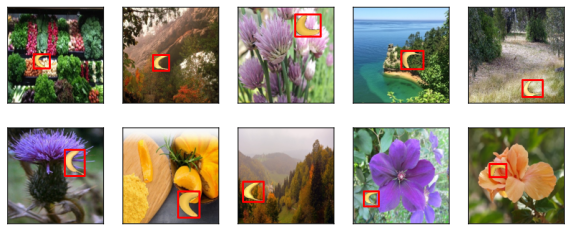

In [ ]:
# batch[0]是features，形状是 批次，通道，高，宽  batch[1]则是labels，形状是 批次，种类，每个种类的5个数据（标签，框坐标）
imgs = (batch[0][0:10].permute(0, 2, 3, 1)) / 255
axes = d2l.show_images(imgs, 2, 5, scale=2)
for ax, label in zip(axes, batch[1][0:10]):
    d2l.show_bboxes(ax, [label[0][1:5] * edge_size], colors=['r'])

# 锚框

In [ ]:
%matplotlib inline
import torch
from d2l import torch as d2l

torch.set_printoptions(4)  # 精简输出精度

In [ ]:
# 以每个像素为中心，生成多个缩放比和宽高比（aspect ratio）不同的边界框。 这些边界框被称为锚框
# data是图片数据，批次，通道，高，宽  sizes是放缩比，0-1的数值组成的list，ratios是锚框高宽比，0-1数值组成的list
def multibox_prior(data, sizes, ratios):
    """生成以每个像素为中心具有不同形状的锚框"""
    in_height, in_width = data.shape[-2:] # 倒数第二个元素到最后 即图片的高和宽
    device, num_sizes, num_ratios = data.device, len(sizes), len(ratios)
    boxes_per_pixel = (num_sizes + num_ratios - 1)  # 每个像素能生成的锚框数量
    # print(f'boxed per pixel: {boxes_per_pixel}')
    size_tensor = torch.tensor(sizes, device=device)   # 转为tensor才能计算
    ratio_tensor = torch.tensor(ratios, device=device)

    # 为了将锚点移动到像素的中心，需要设置偏移量。
    # 因为一个像素的高为1且宽为1，我们选择偏移我们的中心0.5
    offset_h, offset_w = 0.5, 0.5
    steps_h = 1.0 / in_height  # 在y轴上缩放步长
    steps_w = 1.0 / in_width  # 在x轴上缩放步长

    # 生成锚框的所有中心点
    # 百分比的比例
    center_h = (torch.arange(in_height, device=device) + offset_h) * steps_h
    center_w = (torch.arange(in_width, device=device) + offset_w) * steps_w
    # print(f'center_h: {center_h.shape}')
    # print(f'center_w: {center_w.shape}')
    shift_y, shift_x = torch.meshgrid(center_h, center_w, indexing='ij')      # meshgrid生成二维网格，返回xx和yy，两者shape一样，xx矩阵的点对应yy的点就是一个坐标
    # print(f'shift_y: {shift_y.shape}')
    # print(f'shift_x: {shift_x.shape}')
    # 之后就基于 shift_x和y来作为生成中心
    shift_y, shift_x = shift_y.reshape(-1), shift_x.reshape(-1)           # 展平成一维张量
    # print(f'shift_y: {shift_y[10000:10005]}')
    # print(f'shift_x: {shift_x[10000:10005]}')
    # 生成“boxes_per_pixel”个高和宽，
    # 之后用于创建锚框的四角坐标(xmin,xmax,ymin,ymax)
    # w和h都有分为若干个s*r1情况和为s1和若干个r的情况 总共有boxes_per_pixel种情况，所以w为一维数组，长度就是boxes_per_pixel
    # print(f'size_tensor: {size_tensor.shape}')
    # print(f'ratio_tensor: {ratio_tensor.shape}')
    w = torch.cat((size_tensor * torch.sqrt(ratio_tensor[0]),
                   sizes[0] * torch.sqrt(ratio_tensor[1:])))\
                   * in_height / in_width  # 处理矩形输入  除以in_width是将w转为百分比
    h = torch.cat((size_tensor / torch.sqrt(ratio_tensor[0]),
                   sizes[0] / torch.sqrt(ratio_tensor[1:]))) # 得到的是百分比结果
    # print(f'w: {w}')
    # print(f'h: {h.shape}')
    # 除以2来获得半高和半宽
    # stack 堆叠的时候是第一行，第二行堆叠的，所以要转置矩阵，结果是一行代表-w,-h,w,h的组合，有boxes_per_pixel种情况
    # rpeat 表示在行上重复in_height * in_width，列上重复一次  因为每一个像素都有boxes_per_pixel种锚框大小组合
    anchor_manipulations = torch.stack((-w, -h, w, h)).T.repeat(in_height * in_width, 1) / 2 # 这里沿着维度 0 重复in_height * in_width次
    # print(f'in_height * in_width: {in_height * in_width}')
    # print(f'torch.stack((-w, -h, w, h)): {torch.stack((-w, -h, w, h)).T}')
    # print(f'anchor_manipulations shape: {anchor_manipulations.shape}')
    # print(f'anchor_manipulations: {anchor_manipulations[:10]}')


    # 每个中心点都将有“boxes_per_pixel”个锚框，
    # 所以生成含所有锚框中心的网格，重复了“boxes_per_pixel”次
    # 先拼到列上x,y,x,y stack后得到的是图片所有xyxy的坐标组合 假如boxes_per_pixel=5 每个像素5种，那先将基础的元素每一行重复5遍
    # out_grid 结果是再stack后再对每行重复5遍，假如图片大小561*728=408408，那么stack结果就是x和y的组合有408408行，out_grid就是 5*408408 = 2042040
    out_grid = torch.stack([shift_x, shift_y, shift_x, shift_y],
                dim=1).repeat_interleave(boxes_per_pixel, dim=0)
    # print(f'torch.stack([shift_x, shift_y, shift_x, shift_y],dim=1) shape : {torch.stack([shift_x, shift_y, shift_x, shift_y],dim=1).shape}')
    # print(f'torch.stack([shift_x, shift_y, shift_x, shift_y],dim=1): {torch.stack([shift_x, shift_y, shift_x, shift_y],dim=1)[20000:20005]}')
    # print(f'out_grid: {out_grid.shape}')
    # print(f'out_grid: {out_grid[100000:100025]}')
    # 将x,y,x,y和 -w,-h,w,h 求和
    output = out_grid + anchor_manipulations
    # print(f'output: {output.shape}')
    # print(f'output: {output[100000:100025]}')
    # 结果在0维插入一个新维度，本来 2042040,4 变成 1,2042040,4 这个1表示这个图片的框的类别，因为demo中的数据就是香蕉，就一类所以是1
    # print(f'output.unsqueeze(0){output.unsqueeze(0).shape}')
    return output.unsqueeze(0)


In [ ]:
img = d2l.plt.imread('./catdog.jpg')
h, w = img.shape[:2]

print(h, w)
X = torch.rand(size=(1, 3, h, w))
Y = multibox_prior(X, sizes=[0.75, 0.5, 0.25], ratios=[1, 2, 0.5])
Y.shape

561 728


torch.Size([1, 2042040, 4])

In [ ]:
boxes = Y.reshape(h, w, 5, 4)
boxes[250, 250, 0, :]
boxes[102, 102, 0, :]

tensor([-0.1482, -0.1923,  0.4298,  0.5577])

In [ ]:
#画图显示所有框
def show_bboxes(axes, bboxes, labels=None, colors=None):
    """显示所有边界框"""
    def _make_list(obj, default_values=None):
        if obj is None:
            obj = default_values
        elif not isinstance(obj, (list, tuple)):
            obj = [obj]
        return obj

    labels = _make_list(labels)
    colors = _make_list(colors, ['b', 'g', 'r', 'm', 'c'])
    for i, bbox in enumerate(bboxes):
        color = colors[i % len(colors)]
        rect = d2l.bbox_to_rect(bbox.detach().numpy(), color)
        axes.add_patch(rect)
        if labels and len(labels) > i:
            text_color = 'k' if color == 'w' else 'w'
            axes.text(rect.xy[0], rect.xy[1], labels[i],
                      va='center', ha='center', fontsize=9, color=text_color,
                      bbox=dict(facecolor=color, lw=0))

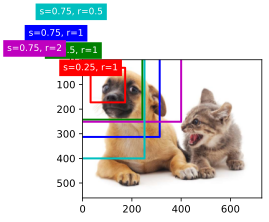

In [ ]:
d2l.set_figsize()
bbox_scale = torch.tensor((w, h, w, h))
fig = d2l.plt.imshow(img)
show_bboxes(fig.axes, boxes[102, 102, :, :] * bbox_scale,
            ['s=0.75, r=1', 's=0.5, r=1', 's=0.25, r=1', 's=0.75, r=2',
             's=0.75, r=0.5'])

In [ ]:
# 计算锚框和边缘框的相似度
# 给定两个锚框或边界框的列表，以下box_iou函数将在这两个列表中计算它们成对的交并比
def box_iou(boxes1, boxes2):
    """计算两个锚框或边界框列表中成对的交并比"""
    # box_area = 面积列表
    box_area = lambda boxes: ((boxes[:, 2] - boxes[:, 0]) *  # x2 -x1 = 宽
                              (boxes[:, 3] - boxes[:, 1])) # y2-y1 = 高
    # boxes1,boxes2,areas1,areas2的形状:
    # boxes1：(boxes1的数量,4),
    # boxes2：(boxes2的数量,4),
    # areas1：(boxes1的数量,),
    # areas2：(boxes2的数量,)
    areas1 = box_area(boxes1)
    areas2 = box_area(boxes2)
    print(f'boxes1: {boxes1.shape}')
    print(f'boxes2: {boxes2.shape}')
    # inter_upperlefts,inter_lowerrights,inters的形状:
    # (boxes1的数量,boxes2的数量,2)
    # torch.max会广播，若boxes1切片后是 5,1,2 boxes2是 3,2 广播后boxes1和2都扩展成5,3,2 所以max结果变成 5,3,2
    inter_upperlefts = torch.max(boxes1[:, None, :2], boxes2[:, :2])    # None表示插入新维度 这里一行对应一个只有x1,y1的结果，从两个列表里取最大值
    inter_lowerrights = torch.min(boxes1[:, None, 2:], boxes2[:, 2:])   # 取两列的最小值 x2,y2
    inters = (inter_lowerrights - inter_upperlefts).clamp(min=0)       # 计算交集的宽度和高度
    print(f'inter_upperlefts: {inter_upperlefts.shape}')
    print(f'inter_lowerrights: {inter_lowerrights.shape}')
    # inter_areasandunion_areas的形状:(boxes1的数量,boxes2的数量)
    inter_areas = inters[:, :, 0] * inters[:, :, 1]           # 计算交集面积
    union_areas = areas1[:, None] + areas2 - inter_areas         # 并集面积 = 两个锚框面积合减去交集
    return inter_areas / union_areas                     # 交集/并集 就是相似度


In [ ]:
testa = boxes[102, 102, :, :]
testb = boxes[250, 250, :3, :]
print(f'testa: {testa}')
print(f'testb: {testb}')
print(f'box_iou(testa,testb): {box_iou(testa,testb)}')

testa: tensor([[-0.1482, -0.1923,  0.4298,  0.5577],
        [-0.0519, -0.0673,  0.3334,  0.4327],
        [ 0.0445,  0.0577,  0.2371,  0.3077],
        [-0.2679, -0.0825,  0.5495,  0.4479],
        [-0.0635, -0.3476,  0.3451,  0.7130]])
testb: tensor([[0.0551, 0.0715, 0.6331, 0.8215],
        [0.1514, 0.1965, 0.5367, 0.6965],
        [0.2478, 0.3215, 0.4404, 0.5715]])
boxes1: torch.Size([5, 4])
boxes2: torch.Size([3, 4])
inter_upperlefts: torch.Size([5, 3, 2])
inter_lowerrights: torch.Size([5, 3, 2])
box_iou(testa,testb): tensor([[0.2660, 0.1913, 0.0980],
        [0.1913, 0.1256, 0.0412],
        [0.0980, 0.0412, 0.0000],
        [0.2733, 0.1830, 0.0532],
        [0.2733, 0.1830, 0.0532]])


In [ ]:
# 对应ipad的笔记，做边缘框和锚框的对应矩阵，每次从矩阵取最大的值，删除对应行列，分配对应锚框和边缘框的关联
# ground_truth 边缘框
# anchors 锚框
def assign_anchor_to_bbox(ground_truth, anchors, device, iou_threshold=0.5):
    """将最接近的真实边界框分配给锚框"""
    num_anchors, num_gt_boxes = anchors.shape[0], ground_truth.shape[0]
    # 位于第i行和第j列的元素x_ij是锚框i和真实边界框j的IoU
    jaccard = box_iou(anchors, ground_truth)
    # 对于每个锚框，分配的真实边界框的张量
    # 这里用来标记每个锚框对应的边缘框，初始都是-1
    anchors_bbox_map = torch.full((num_anchors,), -1, dtype=torch.long,
                                  device=device)
    # 根据阈值，决定是否分配真实边界框
    # max_ious 结果是N*1维张量存储每一行的最大值，indices形状一样，存储每行最大值对应下标
    max_ious, indices = torch.max(jaccard, dim=1)
    # 求出每一行的最大相似度是否大于阈值，大于则返回非0索引
    # 锚框是行所以是 anc_i
    anc_i = torch.nonzero(max_ious >= iou_threshold).reshape(-1)  # 返回非0元素索引
    box_j = indices[max_ious >= iou_threshold]
    anchors_bbox_map[anc_i] = box_j
    col_discard = torch.full((num_anchors,), -1)
    row_discard = torch.full((num_gt_boxes,), -1)

    # 下面这个是遍历所有列（真实框），找到和真实框最匹配的锚框，在锚框映射里赋值给锚框真实框下标
    # 和上面的有点重复，但是不做阈值判断，确保每一个真实框都有一个锚框匹配到
    for _ in range(num_gt_boxes):
        max_idx = torch.argmax(jaccard)  # 不指定维度会先展平，然后返回最大值下标的整数
        box_idx = (max_idx % num_gt_boxes).long()   # 找到最大值所在行
        anc_idx = (max_idx / num_gt_boxes).long()   # 找到最大值所在列
        anchors_bbox_map[anc_idx] = box_idx       # 映射中赋值，每个锚框对应的边缘框
        jaccard[:, box_idx] = col_discard   # 然后这一列置为-1
        jaccard[anc_idx, :] = row_discard   # 然后这一行置为-1
    return anchors_bbox_map

返回的结果中有三个元素，都是张量格式。第三个元素包含标记的输入锚框的类别

In [ ]:
# 计算锚框对应的边缘框的偏移量  两个入参批量大小一致
def offset_boxes(anchors, assigned_bb, eps=1e-6):
    """对锚框偏移量的转换"""
    c_anc = d2l.box_corner_to_center(anchors) # 转为中心表示法
    c_assigned_bb = d2l.box_corner_to_center(assigned_bb)
    # 目标和真实前两个参数都是x,y坐标，获得差值 / 后两者宽高 w,h 即 (x2-x1,y2-y1)/(w,h)
    offset_xy = 10 * (c_assigned_bb[:, :2] - c_anc[:, :2]) / c_anc[:, 2:]
    offset_wh = 5 * torch.log(eps + c_assigned_bb[:, 2:] / c_anc[:, 2:])
    offset = torch.cat([offset_xy, offset_wh], axis=1)
    return offset

In [ ]:
# 将锚框和边缘框作为输入，边缘框内第一列带了物体标签
# 分配锚框对应的标签，没有分配到的锚框类别都是0
# 存在对应边缘框的锚框计算偏移量矩阵，矩阵行是每一个锚框，列是每个锚框对应的边缘框的偏移量，有四列，四种偏移，（x偏差量，y偏差量，宽偏差，高偏差）
# 最后的偏移量矩阵（损失）拉成一维
# 由于锚框对应未分配的坐标都是0，也能算出损失（偏移量），所以计算出一个mask，0表示无关联，1表示有关联
# 每次偏移量矩阵重新算完，都要*一次mask
# 简而言之 mask用于过滤背景
def multibox_target(anchors, labels):
    print(f'anchors shape{anchors.shape}')
    print(f'labels shape{labels.shape}')
    """使用真实边界框标记锚框"""
    batch_size, anchors = labels.shape[0], anchors.squeeze(0) # 去掉第一维为1的维度，批次维度
    batch_offset, batch_mask, batch_class_labels = [], [], []
    device, num_anchors = anchors.device, anchors.shape[0]
    for i in range(batch_size):
        label = labels[i, :, :] # 每个图片的所有真实框 形状 n,5 n个框 每个框5个信息（类别，两个坐标）
        print(f'label {label}')
        anchors_bbox_map = assign_anchor_to_bbox(
            label[:, 1:], anchors, device)
        print(f'anchors_bbox_map {anchors_bbox_map}')
        # 如果锚框有5个，得到5行4列，每列一样的矩阵，一行对应一个锚框，没有分配到边缘框的行都是0
        # 后面和
        bbox_mask = ((anchors_bbox_map >= 0).float().unsqueeze(-1)).repeat(1, 4) # 添加第二个维度且在第二个维度重复四次
        print(f'bbox_mask {bbox_mask}')
        # 将类标签和分配的边界框坐标初始化为零
        class_labels = torch.zeros(num_anchors, dtype=torch.long,
                                   device=device)
        assigned_bb = torch.zeros((num_anchors, 4), dtype=torch.float32,
                                  device=device)
        # 使用真实边界框来标记锚框的类别。
        # 如果一个锚框没有被分配，标记其为背景（值为零）
        indices_true = torch.nonzero(anchors_bbox_map >= 0)
        print(f'indices_true {indices_true}')
        # 被分配的真实锚框id
        bb_idx = anchors_bbox_map[indices_true]
        print(f'bb_idx {bb_idx}')
        # 获得真实框的第一个列即物体label，class_labels结果为每个锚框对应物体类别的一维向量，值为0表示没有分配
        class_labels[indices_true] = label[bb_idx, 0].long() + 1
        print(f'class_labels {class_labels}')
        # 五个锚框对应的真实框坐标，值为0表示未分配
        assigned_bb[indices_true] = label[bb_idx, 1:]
        print(f'assigned_bb {assigned_bb}')

        # 偏移量转换  计算锚框和锚框对应的真实框偏移量，因为有的锚框没有分配，对应的是0，但是锚框自己有坐标，还是能计算出偏移量
        # 所以结果还得再乘 bbox_mask 将无关行置为0
        offset = offset_boxes(anchors, assigned_bb) * bbox_mask
        print(f'offset {offset}')

        batch_offset.append(offset.reshape(-1))
        batch_mask.append(bbox_mask.reshape(-1))
        batch_class_labels.append(class_labels)
        print(f'batch_offset {batch_offset}')
    bbox_offset = torch.stack(batch_offset)
    bbox_mask = torch.stack(batch_mask)
    class_labels = torch.stack(batch_class_labels)
    # 每个图片的所有锚框偏移量拉成了一维的，对应mask也拉成了一维的，每次计算offset完都要重新*mask，mask对应0的地方结果是0
    # 因为锚框自己有坐标，还是能计算出偏移量 所以结果还得再乘 bbox_mask 将无关行置为0
    return (bbox_offset, bbox_mask, class_labels)

In [ ]:
ground_truth = torch.tensor([[0, 0.1, 0.08, 0.52, 0.92],
                         [1, 0.55, 0.2, 0.9, 0.88]])
anchors = torch.tensor([[0, 0.1, 0.2, 0.3], [0.15, 0.2, 0.4, 0.4],
                    [0.63, 0.05, 0.88, 0.98], [0.66, 0.45, 0.8, 0.8],
                    [0.57, 0.3, 0.92, 0.9]])

fig = d2l.plt.imshow(img)
show_bboxes(fig.axes, ground_truth[:, 1:] * bbox_scale, ['dog', 'cat'], 'k')
show_bboxes(fig.axes, anchors * bbox_scale, ['0', '1', '2', '3', '4']);

In [ ]:
labels = multibox_target(anchors.unsqueeze(dim=0),
                         ground_truth.unsqueeze(dim=0))
labels

anchors shapetorch.Size([1, 5, 4])
labels shapetorch.Size([1, 2, 5])
label tensor([[0.0000, 0.1000, 0.0800, 0.5200, 0.9200],
        [1.0000, 0.5500, 0.2000, 0.9000, 0.8800]])
boxes1: torch.Size([5, 4])
boxes2: torch.Size([2, 4])
inter_upperlefts: torch.Size([5, 2, 2])
inter_lowerrights: torch.Size([5, 2, 2])
anchors_bbox_map tensor([-1,  0,  1, -1,  1])
bbox_mask tensor([[0., 0., 0., 0.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [0., 0., 0., 0.],
        [1., 1., 1., 1.]])
indices_true tensor([[1],
        [2],
        [4]])
bb_idx tensor([[0],
        [1],
        [1]])
class_labels tensor([0, 1, 2, 0, 2])
assigned_bb tensor([[0.0000, 0.0000, 0.0000, 0.0000],
        [0.1000, 0.0800, 0.5200, 0.9200],
        [0.5500, 0.2000, 0.9000, 0.8800],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.5500, 0.2000, 0.9000, 0.8800]])
offset tensor([[-0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00],
        [ 1.4000e+00,  1.0000e+01,  2.5940e+00,  7.1754e+00],
        [-1

(tensor([[-0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00,  1.4000e+00,
           1.0000e+01,  2.5940e+00,  7.1754e+00, -1.2000e+00,  2.6882e-01,
           1.6824e+00, -1.5655e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00,
          -0.0000e+00, -5.7143e-01, -1.0000e+00,  4.1723e-06,  6.2582e-01]]),
 tensor([[0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 1., 1.,
          1., 1.]]),
 tensor([[0, 1, 2, 0, 2]]))

使用非极大值抑制预测边界框

In [ ]:
def offset_inverse(anchors, offset_preds):
    """根据带有预测偏移量的锚框来预测边界框"""
    anc = d2l.box_corner_to_center(anchors)
    pred_bbox_xy = (offset_preds[:, :2] * anc[:, 2:] / 10) + anc[:, :2]
    pred_bbox_wh = torch.exp(offset_preds[:, 2:] / 5) * anc[:, 2:]
    pred_bbox = torch.cat((pred_bbox_xy, pred_bbox_wh), axis=1)
    predicted_bbox = d2l.box_center_to_corner(pred_bbox)
    return predicted_bbox

In [ ]:
def nms(boxes, scores, iou_threshold):
    """对预测边界框的置信度进行排序"""
    B = torch.argsort(scores, dim=-1, descending=True)
    keep = []  # 保留预测边界框的指标
    while B.numel() > 0:
        i = B[0]
        keep.append(i)
        if B.numel() == 1: break
        iou = box_iou(boxes[i, :].reshape(-1, 4),
                      boxes[B[1:], :].reshape(-1, 4)).reshape(-1)
        inds = torch.nonzero(iou <= iou_threshold).reshape(-1)
        B = B[inds + 1]
    return torch.tensor(keep, device=boxes.device)

In [ ]:
def multibox_detection(cls_probs, offset_preds, anchors, nms_threshold=0.5,
                       pos_threshold=0.009999999):
    """使用非极大值抑制来预测边界框"""
    device, batch_size = cls_probs.device, cls_probs.shape[0]
    anchors = anchors.squeeze(0)
    num_classes, num_anchors = cls_probs.shape[1], cls_probs.shape[2]
    out = []
    for i in range(batch_size):
        cls_prob, offset_pred = cls_probs[i], offset_preds[i].reshape(-1, 4)
        conf, class_id = torch.max(cls_prob[1:], 0)
        predicted_bb = offset_inverse(anchors, offset_pred)
        keep = nms(predicted_bb, conf, nms_threshold)

        # 找到所有的non_keep索引，并将类设置为背景
        all_idx = torch.arange(num_anchors, dtype=torch.long, device=device)
        combined = torch.cat((keep, all_idx))
        uniques, counts = combined.unique(return_counts=True)
        non_keep = uniques[counts == 1]
        all_id_sorted = torch.cat((keep, non_keep))
        class_id[non_keep] = -1
        class_id = class_id[all_id_sorted]
        conf, predicted_bb = conf[all_id_sorted], predicted_bb[all_id_sorted]
        # pos_threshold是一个用于非背景预测的阈值
        below_min_idx = (conf < pos_threshold)
        class_id[below_min_idx] = -1
        conf[below_min_idx] = 1 - conf[below_min_idx]
        pred_info = torch.cat((class_id.unsqueeze(1),
                               conf.unsqueeze(1),
                               predicted_bb), dim=1)
        out.append(pred_info)
    return torch.stack(out)

In [ ]:
anchors = torch.tensor([[0.1, 0.08, 0.52, 0.92], [0.08, 0.2, 0.56, 0.95],
                      [0.15, 0.3, 0.62, 0.91], [0.55, 0.2, 0.9, 0.88]])
offset_preds = torch.tensor([0] * anchors.numel())
cls_probs = torch.tensor([[0] * 4,  # 背景的预测概率
                      [0.9, 0.8, 0.7, 0.1],  # 狗的预测概率
                      [0.1, 0.2, 0.3, 0.9]])  # 猫的预测概率

In [ ]:
output = multibox_detection(cls_probs.unsqueeze(dim=0),
                            offset_preds.unsqueeze(dim=0),
                            anchors.unsqueeze(dim=0),
                            nms_threshold=0.5)
output

boxes1: torch.Size([1, 4])
boxes2: torch.Size([3, 4])
inter_upperlefts: torch.Size([1, 3, 2])
inter_lowerrights: torch.Size([1, 3, 2])


tensor([[[ 0.0000,  0.9000,  0.1000,  0.0800,  0.5200,  0.9200],
         [ 1.0000,  0.9000,  0.5500,  0.2000,  0.9000,  0.8800],
         [-1.0000,  0.8000,  0.0800,  0.2000,  0.5600,  0.9500],
         [-1.0000,  0.7000,  0.1500,  0.3000,  0.6200,  0.9100]]])